In [3]:
import numpy as np
import theano
import theano.tensor as T
import pickle

from mnist import load_dataset

from IPython import display

import matplotlib.pyplot as plt
import matplotlib
# %matplotlib inline
matplotlib.style.use('ggplot')

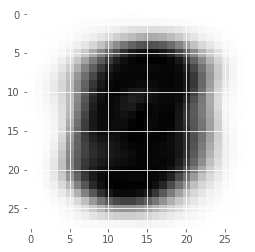

(26, 22)


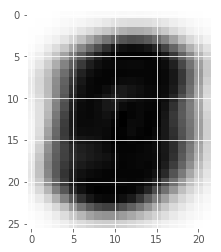

Training (50000, 1, 26, 22) (50000,)
Validation (10000, 1, 26, 22) (10000,)
Test (10000, 1, 26, 22) (10000,)


In [4]:
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

hot_points = np.std(X_train[:,0,...],axis=0)
plt.imshow(hot_points, cmap='Greys')
plt.show()
H = np.arange(1, 27)
W = np.arange(3, 25)
print(hot_points[H][:,W].shape)
plt.imshow(hot_points[H][:,W], cmap='Greys')
plt.show()

X_test = X_test[..., H, :][..., W]
X_train = X_train[..., H, :][..., W]
X_val = X_val[..., H, :][..., W]

print('Training', X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

### Save weights

In [10]:
__code__ = str(54216786)

__file_path__ = './params_' + __code__

In [9]:
def dump():
    saved_parameters = []
    for parameter in parameters:
        saved_parameters.append(parameter.get_value())
    save = ((loss_history,train_acc_history,val_acc_history),
            saved_parameters,
            epoch)
    with open(__file_path__, 'wb') as output_stream:
        pickle.dump(save, output_stream, -1)
        
def save_weights(all_weights):
    global all_weights_saved
    all_weights_saved = []
    for weight in all_weights:
        all_weights_saved.append(weight.get_value())

def restore_weights(all_weights):
    global all_weights_saved
    assert len(all_weights) == len(all_weights_saved)
    for weight, weight_saved in zip(all_weights, all_weights_saved):
        weight.set_value(weight_saved)

In [4]:
print('Training', X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Training (50000, 1, 24, 18) (50000,)
Validation (10000, 1, 24, 18) (10000,)
Test (10000, 1, 24, 18) (10000,)


### Building network

In [5]:
input_X = T.tensor4('X')
input_shape = [None]
input_shape.extend(X_train.shape[1:])
print(input_shape)
target_y = T.vector("target Y integer",dtype='int32')


[None, 1, 26, 22]


In [6]:
import lasagne
from lasagne.layers import *

layer = InputLayer(shape = input_shape,input_var=input_X)
layer = Conv2DLayer(layer, num_filters=34, filter_size=(5, 5), pad='same', nonlinearity=lasagne.nonlinearities.rectify)
layer = MaxPool2DLayer(layer, (2,2))
layer = Conv2DLayer(layer, num_filters=31, filter_size=(5, 5), pad='same', nonlinearity=lasagne.nonlinearities.rectify)
layer = MaxPool2DLayer(layer, (2,2))
layer = DropoutLayer(layer, p=0.5)
layer = DenseLayer(layer, num_units=911, nonlinearity=lasagne.nonlinearities.rectify)
layer = DropoutLayer(layer, p=0.3)

layer = DenseLayer(layer,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)


In [7]:
y_predicted = lasagne.layers.get_output(layer)
y_test_predicted = lasagne.layers.get_output(layer, deterministic=True)
parameters = lasagne.layers.get_all_params(layer)
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_test_predicted,target_y).mean()
updates_sgd = lasagne.updates.nesterov_momentum(loss, parameters, learning_rate=0.09,momentum=0.82)
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)
accuracy_fun = theano.function([input_X,target_y],accuracy)


In [8]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

## Load reserved weights

In [11]:
with open(__file_path__, 'rb') as input_stream:
    history, saved_parameters, epoch = pickle.load(input_stream)
    for saved_parameter, parameter in zip(saved_parameters, parameters):
        parameter.set_value(np.array(saved_parameter,dtype='float32'))
    last_saved_epoch = epoch

# Training loop

In [14]:
loss_history = []
val_acc_history = []
train_acc_history = []

Epoch 2 of 1000 took 8.291s
  training loss (in-iteration):		0.004813
  train accuracy:		100.00 %
  validation accuracy:		99.56 %


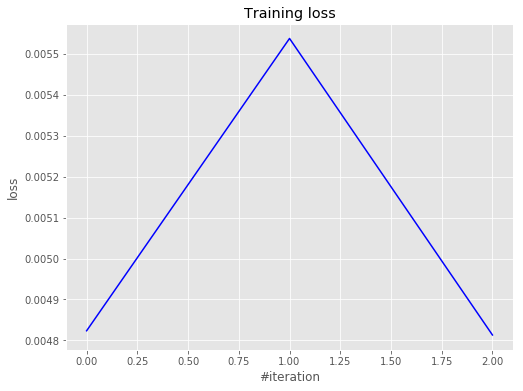

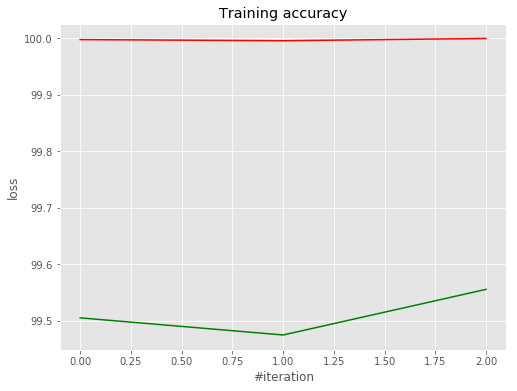

KeyboardInterrupt: 

In [16]:
import time

num_epochs = 1000 #amount of passes through the data

batch_size = 300 #number of samples processed at each function call

for epoch in range(num_epochs):
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    loss = train_err / train_batches
    val_acc = val_acc / val_batches * 100
    train_acc = train_acc / train_batches * 100
    loss_history.append(loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

#     print("Epoch {} took {:.3f}s (last saved epoch {})".format(epoch,  time.time() - start_time, last_saved_epoch))
#     print("  training loss:\t\t{:.6f}".format(loss))
#     print("  train accuracy:\t{:.2f} %".format(train_acc))
#     print("  validation accuracy:\t{:.2f} %".format(val_acc))
    if epoch % 300 == 299:
        dump()
        print('Saved!!!')
    
#     print('Current loss: %f' % loss)   
    # Then we print the results for this epoch:
    if epoch % 1 == 0:
        display.clear_output(wait=True)

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration):\t\t{:.6f}".format(loss))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc))
        plt.figure(figsize=(8, 6))
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.figure(figsize=(8, 6))
        plt.title("Training accuracy")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(train_acc_history, 'r')
        plt.plot(val_acc_history, 'g')
        
        plt.show()

In [12]:
def accuracy(X, y):
    acc = 0
    batches = 0
    for batch in iterate_minibatches(X, y, 500):
        inputs, targets = batch
        acc = acc + accuracy_fun(inputs, targets)
        batches += 1
    return acc*1. / batches

In [17]:
print('Epoch: {}'.format(last_saved_epoch))
print("Training set accuracy:\t\t{:.2f} %".format(accuracy(X_train, y_train) * 100))
print("Validation set accuracy:\t{:.2f} %".format(accuracy(X_val, y_val) * 100))
print("Test set accuracy:\t\t{:.2f} %".format(accuracy(X_test, y_test) * 100))


Epoch: 114
Training set accuracy:		100.00 %
Validation set accuracy:	99.53 %
Test set accuracy:		99.58 %
